# TM10007 Assignment

In [317]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Import packages

In [318]:
import pandas as pd

from worcgist.load_data import load_data

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold, mutual_info_classif
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 1. Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [319]:
# Load data
data = load_data()

data['label'] = data['label'].map({'non-GIST': 0, 'GIST': 1})

y = data['label']
X = data.drop(columns=['label'])

# Splitting the data: 85% for training/validation, 15% for final testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

### 1.1: Basic statistics

Basic statistics:
       Set  Number of samples
0  X_train                209
1  y_train                209
2   X_test                 37
3   y_test                 37

- The number of features: 493
- The number of datapoints: 103037
- The number of missing values: 0
- The number of zero values: 5689
- The percentage of zero values: 0.11743354329027438 %



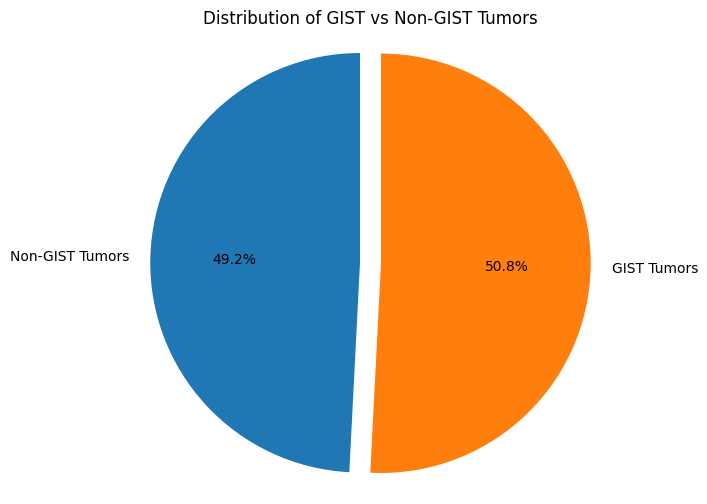

In [320]:
# Calculate basic statistics
data_sizes = {
    'Set': ['X_train', 'y_train', 'X_test', 'y_test'],
    'Number of samples': [len(X_train), len(y_train), len(X_test), len(y_test)]
    }
# Convert to DataFrame
summary_df = pd.DataFrame(data_sizes)
n_samples = len(X_train)
n_features = len(X_train.columns)

n_missing = X_train.isna().sum().sum()
n_zero = (X_train == 0).sum().sum()

n_non_gist = (y == 0).sum().sum()
n_gist = (y == 1).sum().sum()

# Print basic statistics
print("Basic statistics:")
print(summary_df)

print(f'\n- The number of features: {n_features}')
print(f'- The number of datapoints: {n_samples * n_features}')
print(f"- The number of missing values: {n_missing}")
print(f"- The number of zero values: {n_zero}")
print(f"- The percentage of zero values: {n_non_gist/(n_samples*n_features)*100} %\n")

# Data for the pie chart
labels = ['Non-GIST Tumors', 'GIST Tumors']
sizes = [n_non_gist, n_gist]
explode = (0.05, 0.05)  # Slightly "explode" both slices for emphasis

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Distribution of GIST vs Non-GIST Tumors')
plt.axis('equal')
plt.show()


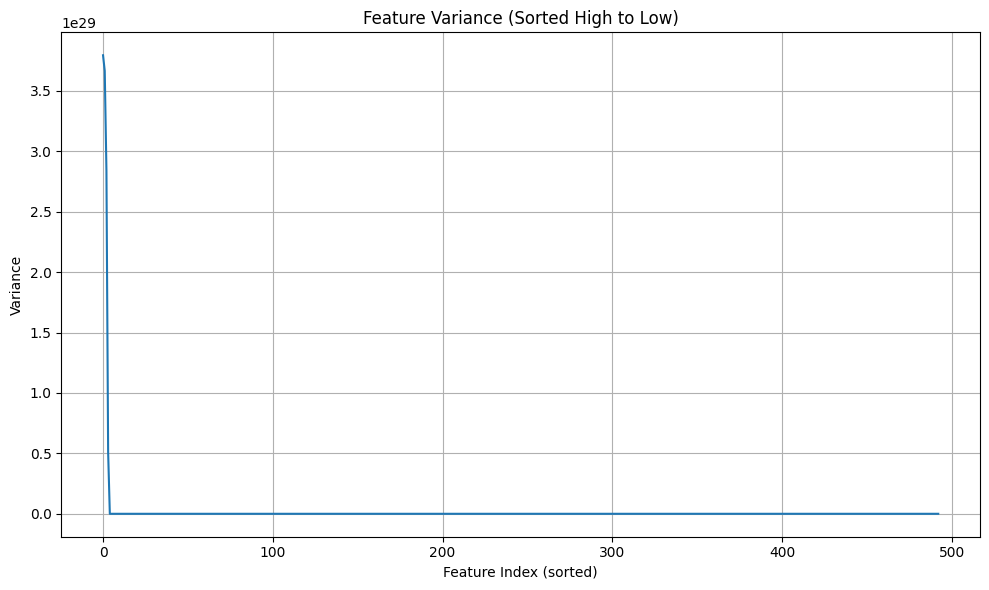

In [321]:
variances = X_train.var()  # Get variance of each column
variances_sorted = variances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(variances_sorted.values)
plt.ylabel('Variance')
plt.xlabel('Feature Index (sorted)')
plt.title('Feature Variance (Sorted High to Low)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Pre-processing

The training data was preprocessed in 3 steps:


1.   Outliers replacecement
2.   Scaling
3.   Low variance features removed



### 2.1: Replace outliers

In [322]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro

# Parameters
threshold_nd = 3.0   # Z-score threshold for normal distribution
threshold_nnd = 1.5  # IQR threshold for non-normal distribution

# Zorg dat X_train en X_test DataFrames zijn
#X_train = X_train.astype(float).copy()
#X_test = X_test.astype(float).copy()

# --- Step 1: determine normality using Shapiro-Wilk ---
alpha = 0.05
normal_results = {}

for col in X_train.columns:
    p_value = shapiro(X_train[col])[1]  # Get p-value only
    normal_results[col] = p_value > alpha  # True = normal distribution

is_normal = pd.Series(normal_results) # Save normality as a series

# --- Step 2:  ---
bounds = {}
outliers_replaced_train = 0
outliers_replaced_test = 0


X_train_clipped = X_train.copy()
X_test_clipped = X_test.copy()

for column in X_train.columns:
    if is_normal[column]:
        # Normale verdeling → Z-score
        mean = X_train[column].mean()
        std = X_train[column].std()
        lower = mean - threshold_nd * std
        upper = mean + threshold_nd * std
    else:
        # Niet-normaal → IQR
        Q1 = X_train[column].quantile(0.25)
        Q3 = X_train[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold_nnd * IQR
        upper = Q3 + threshold_nnd * IQR

    bounds[column] = (lower, upper)

    # Aantal outliers vóór clipping
    outliers_train = ((X_train[column] < lower) | (X_train[column] > upper)).sum()
    outliers_test = ((X_test[column] < lower) | (X_test[column] > upper)).sum()
    outliers_replaced_train += outliers_train
    outliers_replaced_test += outliers_test

    # Clipping toepassen
    X_train_clipped[column] = X_train[column].clip(lower, upper)
    X_test_clipped[column] = X_test[column].clip(lower, upper)

# ======= Stap 3: Informatie tonen =======
print(f"- Number of outliers clipped in training set: {outliers_replaced_train}")
print(f"- Number of outliers clipped in test set:     {outliers_replaced_test}")
print(f"- Number of normally distributed features:         {is_normal.sum()}")
print(f"- Number of non-normally distributed features:    {(~is_normal).sum()}")


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


- Number of outliers clipped in training set: 5269
- Number of outliers clipped in test set:     749
- Number of normally distributed features:         59
- Number of non-normally distributed features:    434


### 2.2. Apply scaler

In [323]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_train_clipped)
X_scaled_df = pd.DataFrame(X_scaled)

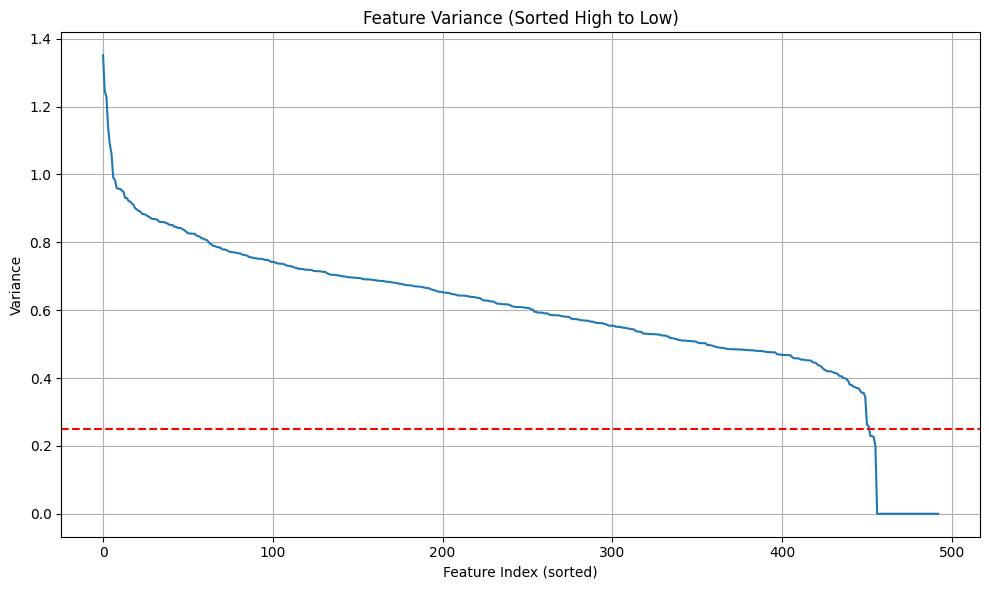

In [324]:
variances = X_scaled_df.var()  # Get variance of each column
variances_sorted = variances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(variances_sorted.values)
plt.axhline(y=0.25, color='red', linestyle='--')
plt.ylabel('Variance')
plt.xlabel('Feature Index (sorted)')
plt.title('Feature Variance (Sorted High to Low)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.3: Variance threshold

In [325]:
# # Step 2: Remove features with low variance
# var_threshold = 0.25
# selector = VarianceThreshold(threshold=var_threshold)

# X_train_reduced = selector.fit_transform(X_scaled)
# X_test_reduced = selector.transform(X_test)

# selected_features = X.columns[selector.get_support()]

# X_train_reduced_df = pd.DataFrame(X_train_reduced, columns=selected_features)
# X_test_reduced_df = pd.DataFrame(X_test_reduced, columns=selected_features)

# n_selected_features = X_train_reduced_df.shape[1]
# n_removed_features = n_features - n_selected_features
# print(f"Number of features removed: {n_removed_features}")

Number of features removed: 41


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but VarianceThreshold was fitted without feature names
  warnings.warn(


In [326]:
# variances = X_train_reduced_df.var()  # Get variance of each column
# variances_sorted = variances.sort_values(ascending=False)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(variances_sorted.values)
# plt.axhline(y=var_threshold, color='red', linestyle='--')
# plt.ylabel('Variance')
# plt.xlabel('Feature Index (sorted)')
# plt.title('Feature Variance (Sorted High to Low)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

## 3. Model training pipeline

### 3.1. Model pipelines

In [382]:
# Define pipelines for each classifier.

pipeline_svm = Pipeline([
    ('scaler', RobustScaler()),
    ('remove_low_variance', VarianceThreshold(threshold=0.01)),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))])

pipeline_rf = Pipeline([
    ('remove_low_variance', VarianceThreshold(threshold=0.01)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))])

pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),
    ('remove_low_variance', VarianceThreshold(threshold=0.01)),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('XGB', XGBClassifier(random_state=42))])

pipeline_knn = Pipeline([
    ('scaler', RobustScaler()),
    ('remove_low_variance', VarianceThreshold(threshold=0.01)),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('knn', KNeighborsClassifier())])

from sklearn.ensemble import GradientBoostingClassifier
pipeline_gb = Pipeline([
    ('scaler', RobustScaler()),
    ('remove_low_variance', VarianceThreshold(threshold=0.01)),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

In [328]:
# Pipelines to be deleted?
# pipeline_dt = Pipeline([
#     ('pca', PCA(n_components=10)),
#     ('DT',DecisionTreeClassifier(random_state=42))
# ])
# pipeline_lr = Pipeline([
#     ('feature_selection', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1'))),
#     ('lr', LogisticRegression(max_iter=1000, random_state=42))
# ])
# pipeline_knn = Pipeline([
#     ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
#     ('knn', KNeighborsClassifier())
# ])
# pipeline_mlp = Pipeline([
#     ('scaler', RobustScaler()),
#     ('remove_low_variance', VarianceThreshold(threshold=0.01)),
#     ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
#     ('mlp', MLPClassifier(early_stopping=True, random_state=42))
# ])
# pipeline_logreg = Pipeline([
#     ('scaler', RobustScaler()),
#     ('variance', VarianceThreshold(threshold=0.01)),
#     ('pca', PCA()),
#     ('logreg', LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42))
# ])

### 3.2: Defining hyperparameter grids

In [383]:
# Define hyperparameter grids for the models
svm_param_grid = [
    {
        'feature_selection__k': [50, 100, 150],
        'svm__kernel': ['linear'],
        'svm__C': [0.01, 0.1, 1, 10, 100],
        # 'svm__class_weight': ['balanced']
    },
    {
        'feature_selection__k': [50, 100, 150],
        'svm__kernel': ['rbf'],
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],
        # 'svm__class_weight': ['balanced']
    }
    ]


rf_param_grid = [{
        'rf__max_depth': [3, 5, 7],
        'rf__min_samples_leaf': [5, 10],
    # 'rf__class_weight': ['balanced']
    }]

xgb_param_grid = [{
        # 'feature_selection__k': [50, 100, 150],
        'XGB__max_depth': [3, 5],
        'XGB__learning_rate': [0.01, 0.1],
        'XGB__subsample': [0.5, 0.8]
}]

# logreg_param_grid = [{
#     'pca__n_components': [10, 20, 30, 50, 75, 100],
#     'logreg__C': [0.01, 0.1, 1, 10, 100]
# }]

In [370]:
# To be deleted?
param_range = [1, 2, 3, 4, 5, 6]
# param_range_fl = [1.0, 0.5, 0.1]
# n_estimators = [50,100,150]
# learning_rates = [.1,.2,.3]

# svm_param_grid = [{'svm__kernel': ['linear', 'rbf'],
#                     'svm__C': param_range}]

# rf_param_grid = [{'rf__min_samples_leaf': param_range,
#                    'rf__max_depth': param_range,
#                    'rf__min_samples_split': param_range[1:]}]

# dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
#                    'DT__min_samples_leaf': param_range,
#                    'DT__max_depth': param_range,
#                    'DT__min_samples_split': param_range[1:]}]

knn_param_grid = [{'feature_selection__k': [50, 100, 150],
                   'knn__n_neighbors': param_range,
                   'knn__weights': ['uniform', 'distance'],
                   'knn__metric': ['euclidean', 'manhattan']}]

gb_param_grid = [{'feature_selection__k': [50, 100, 150],
    'gb__n_estimators': [50, 100],
    'gb__learning_rate': [0.01, 0.1],
    'gb__max_depth': [3, 5],
    'gb__min_samples_leaf': [5, 10],
    'gb__subsample': [0.5, 0.8]
}]
# lr_param_grid = [{'lr__penalty': ['l1', 'l2'],
#                    'lr__C': param_range_fl,
#                    'lr__solver': ['liblinear']}]

# mlp_param_grid = [{'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
#                    'mlp__activation': ['tanh', 'relu'],
#                    'mlp__solver': ['adam'],
#                    'mlp__alpha': [0.0001, 0.001],
#                    'mlp__learning_rate': ['constant','adaptive']}]

# xgb_param_grid = [{'XGB__learning_rate': learning_rates,
#                     'XGB__max_depth': param_range,
#                     'XGB__min_child_weight': param_range[:2],
#                     'XGB__subsample': param_range_fl,
#                     'XGB__n_estimators': n_estimators}]

### 3.3: Setup grid search

In [384]:
# Setup grid search
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

svm_grid_search = GridSearchCV(estimator=pipeline_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1)

rf_grid_search = GridSearchCV(estimator=pipeline_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1)

xgb_grid_search = GridSearchCV(estimator=pipeline_xgb,
        param_grid=xgb_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1)

knn_grid_search = GridSearchCV(estimator=pipeline_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=cv)

gb_grid_search = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=gb_param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    refit=True
)
grids = [svm_grid_search, rf_grid_search, xgb_grid_search]
# grids = [gb_grid_search]
grid_dict = {0: 'Support Vector Machine', 1: 'Random Forrest', 2: 'XGBoost'}

In [332]:
# To be deleted?
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# svm_grid_search = GridSearchCV(estimator=pipeline_svm,
#         param_grid=svm_param_grid,
#         scoring='accuracy',
#         cv=cv)
# rf_grid_search = GridSearchCV(estimator=pipeline_rf,
#         param_grid=rf_param_grid,
#         scoring='accuracy',
#         cv=cv)
# dt_grid_search = GridSearchCV(estimator=pipeline_dt,
#         param_grid=dt_param_grid,
#         scoring='accuracy',
#         cv=cv)
# knn_grid_search = GridSearchCV(estimator=pipeline_knn,
#         param_grid=knn_param_grid,
#         scoring='accuracy',
#         cv=cv)
# lr_grid_search = GridSearchCV(estimator=pipeline_lr,
#         param_grid=lr_param_grid,
#         scoring='accuracy',
#         cv=cv)
# mlp_grid_search = GridSearchCV(estimator=pipeline_mlp,
#         param_grid=mlp_param_grid,
#         scoring='accuracy',
#         cv=cv)
# xgb_grid_search = GridSearchCV(estimator=pipeline_xgb,
#         param_grid=xgb_param_grid,
#         scoring='accuracy',
#         cv=cv)
# logreg_grid_search = GridSearchCV(estimator=pipeline_logreg,
#         param_grid=logreg_param_grid,
#         scoring='accuracy',
#         cv=cv,
#         n_jobs=-1)
# grids = [svm_grid_search, rf_grid_search, dt_grid_search, knn_grid_search, lr_grid_search, mlp_grid_search, xgb_grid_search]
# grids = [logreg_grid_search]

### 3.4: Execute training

In [385]:
for pipe in grids:
    pipe.fit(X_train_clipped,y_train)

## 4. Model evaluation

In [334]:
# # grid_dict = {0: 'Support Vector Machine', 1: 'Random Forrest', 2: 'Decision Tree',
# #              3: 'K Nearest Neighbor', 4: 'Logistic Regression', 5: 'multi-layer perceptron',
# #              6: 'XGBoost'}

# grid_dict = {0: 'Support Vector Machine', 1: 'Random Forrest', 2: 'XGBoost'}
# results_list = []

# for i, model in enumerate(grids):
#     model_name = grid_dict[i]
#     accuracy = model.score(X_test_reduced_df, y_test)
#     best_params = model.best_params_

#     results_list.append({
#         'Model': model_name,
#         'Test Accuracy': accuracy,
#         'Best Hyperparameters': best_params
#     })

# results_df = pd.DataFrame(results_list)
# results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)

# from IPython.display import display

# pd.set_option('display.max_colwidth', 200)
# display(results_df)


=== Support Vector Machine ===
Accuracy: 0.7297
Precision: 0.7143
Recall: 0.7895
F1-score: 0.7500
ROC AUC (test): 0.7719
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.71      0.79      0.75        19

    accuracy                           0.73        37
   macro avg       0.73      0.73      0.73        37
weighted avg       0.73      0.73      0.73        37


Best Hyperparameters: {'feature_selection__k': 50, 'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}



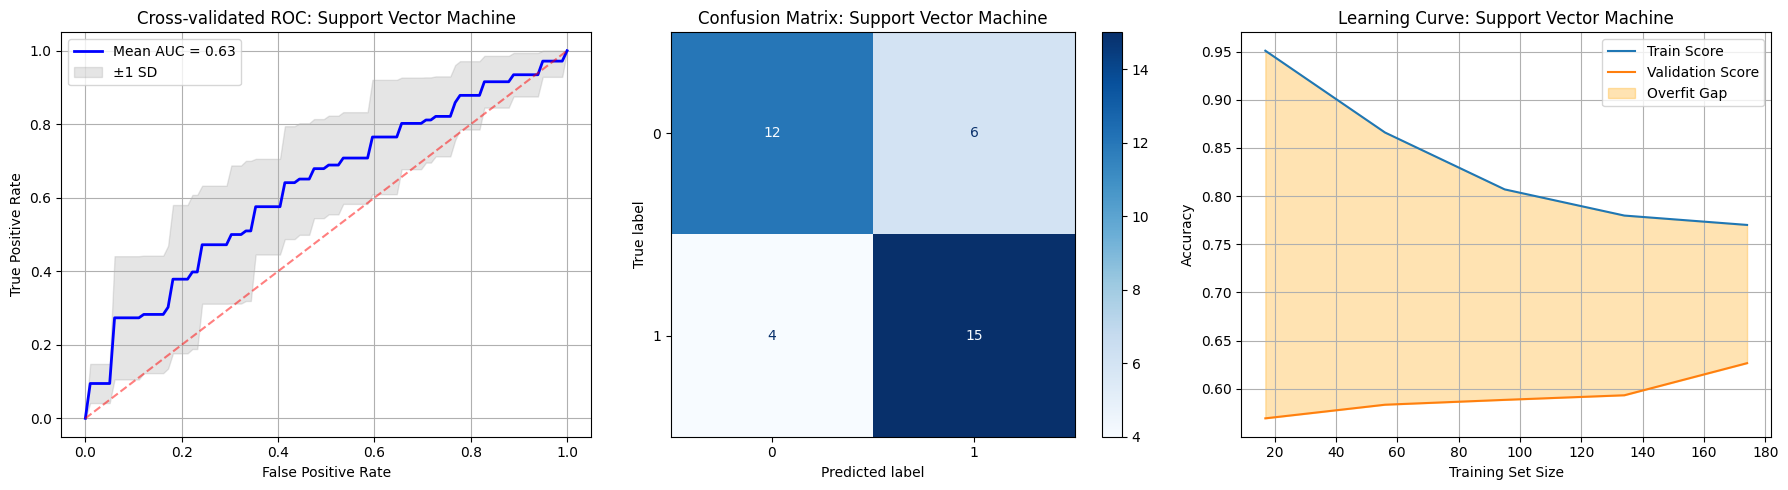


=== Random Forrest ===
Accuracy: 0.7027
Precision: 0.7000
Recall: 0.7368
F1-score: 0.7179
ROC AUC (test): 0.7222
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.70      0.74      0.72        19

    accuracy                           0.70        37
   macro avg       0.70      0.70      0.70        37
weighted avg       0.70      0.70      0.70        37


Best Hyperparameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 10}



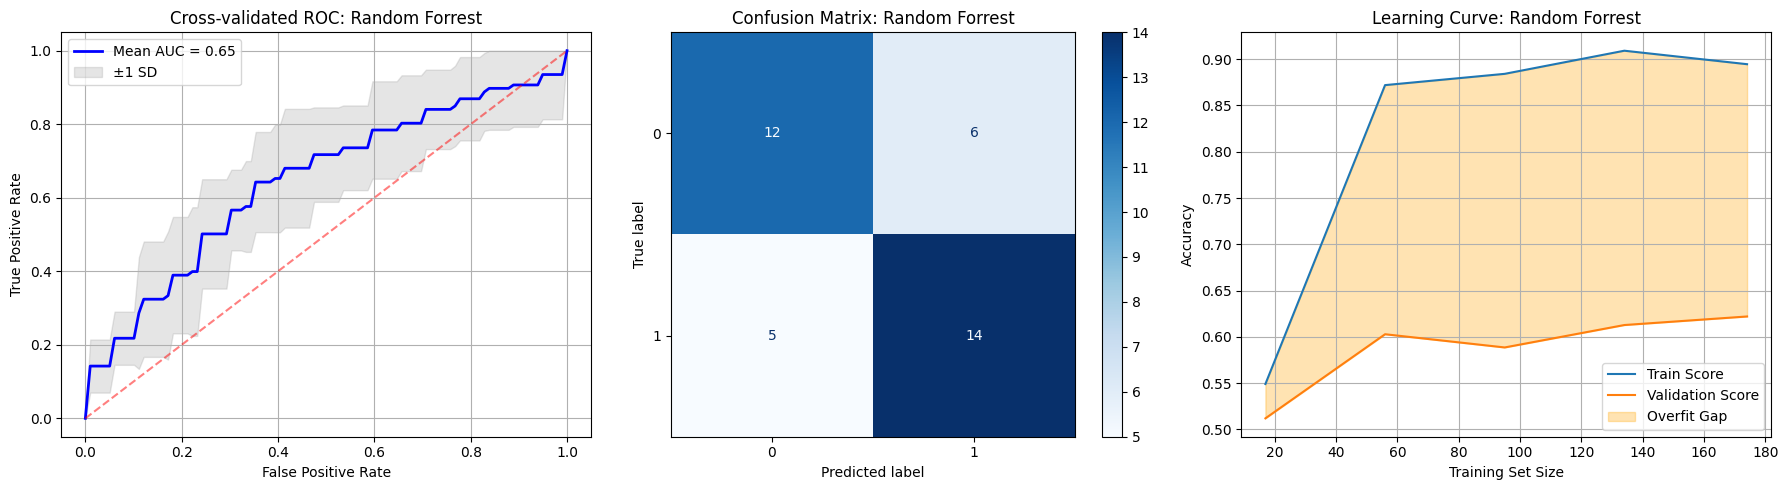


=== XGBoost ===
Accuracy: 0.7027
Precision: 0.7222
Recall: 0.6842
F1-score: 0.7027
ROC AUC (test): 0.7251
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        18
           1       0.72      0.68      0.70        19

    accuracy                           0.70        37
   macro avg       0.70      0.70      0.70        37
weighted avg       0.70      0.70      0.70        37


Best Hyperparameters: {'XGB__learning_rate': 0.1, 'XGB__max_depth': 3, 'XGB__subsample': 0.8}



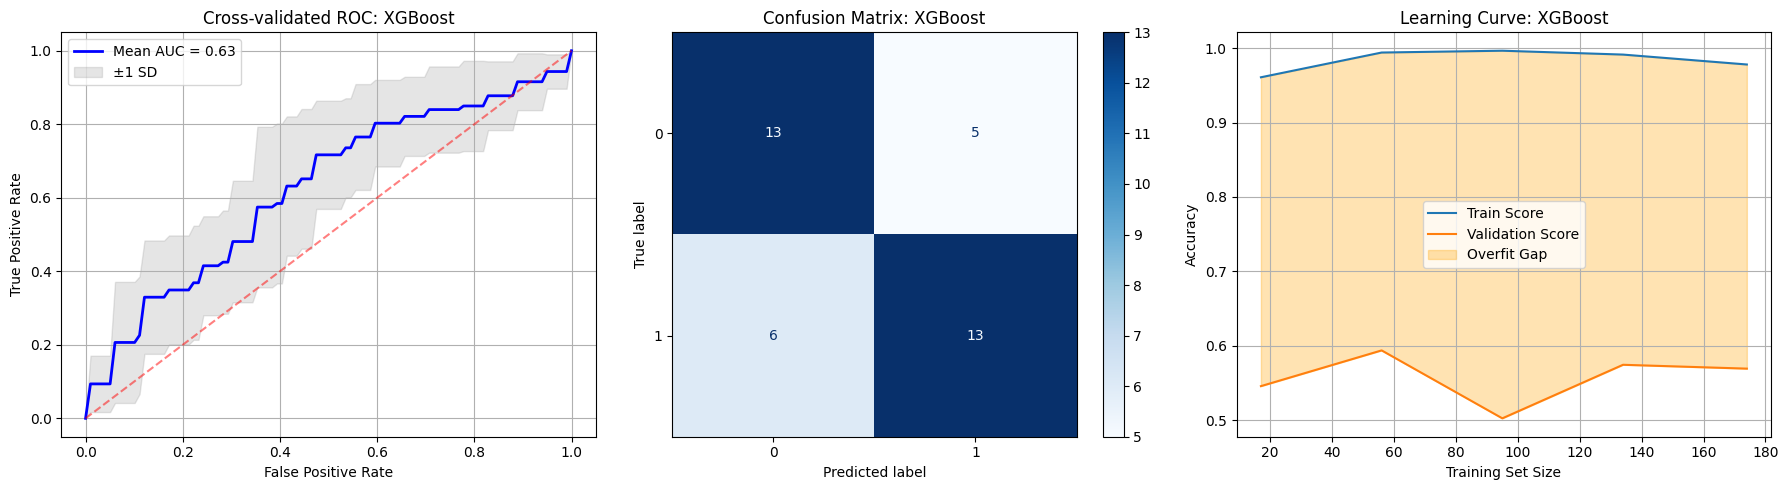

In [388]:
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    classification_report, roc_auc_score,
    ConfusionMatrixDisplay, precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt

def plot_evaluation_figures(model, model_name, X_train, y_train, X_test, y_test, cv):
    """
    Genereert:
    - Cross-validated ROC
    - Confusion matrix op testset
    - Learning curve (train vs. val)
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    cv = cv

    # --- ROC met cross-validation ---
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    for train_idx, val_idx in cv.split(X_train, y_train):
        model_clone = clone(model.best_estimator_)
        model_clone.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        y_val_proba = model_clone.predict_proba(X_train.iloc[val_idx])[:, 1]

        fpr, tpr, _ = roc_curve(y_train.iloc[val_idx], y_val_proba)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    axes[0].plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean AUC = {mean_auc:.2f}')
    axes[0].fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1),
                         color='grey', alpha=0.2, label='±1 SD')
    axes[0].plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='red', alpha=0.5)
    axes[0].set_title(f'Cross-validated ROC: {model_name}')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()
    axes[0].grid(True)

    # --- Confusion matrix ---
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=model.classes_,
                                            cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix: {model_name}')

    # --- Learning curve ---
    train_sizes, train_scores, val_scores = learning_curve(
        model.best_estimator_, X_train, y_train,
        cv=cv, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    axes[2].plot(train_sizes, train_mean, label='Train Score')
    axes[2].plot(train_sizes, val_mean, label='Validation Score')
    axes[2].fill_between(train_sizes, train_mean, val_mean, color='orange', alpha=0.3, label='Overfit Gap')
    axes[2].set_title(f'Learning Curve: {model_name}')
    axes[2].set_xlabel('Training Set Size')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_single_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Voert evaluatie en visualisatie uit voor één model.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_test, y_proba)
    best_params = model.best_params_

    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC (test): {auc_score:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"\nBest Hyperparameters: {best_params}\n")

    plot_evaluation_figures(model, model_name, X_train, y_train, X_test, y_test, cv)


def evaluate_models(grids, grid_dict, X_train, y_train, X_test, y_test, cv):
    """
    Doorloopt een lijst van modellen en voert evaluatie per model uit.
    """
    for i, model in enumerate(grids):
        model_name = grid_dict[i]
        evaluate_single_model(model, model_name, X_train, y_train, X_test, y_test)

evaluate_models(grids, grid_dict, X_train_clipped, y_train, X_test_clipped, y_test, cv)


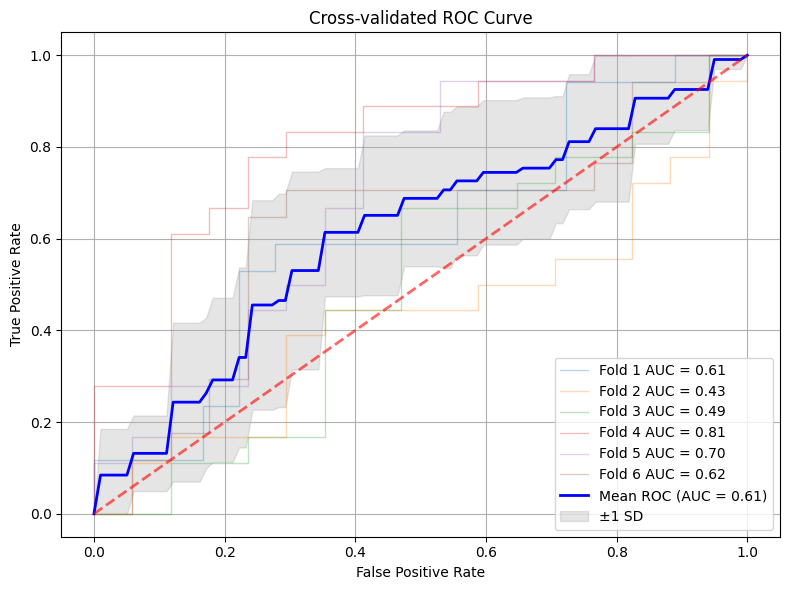

In [374]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))

for i, (train_idx, val_idx) in enumerate(cv.split(X_train_clipped, y_train)):
    model_clone = clone(model.best_estimator_)
    model_clone.fit(X_train_clipped.iloc[train_idx], y_train.iloc[train_idx])
    y_proba = model_clone.predict_proba(X_train_clipped.iloc[val_idx])[:, 1]

    fpr, tpr, _ = roc_curve(y_train.iloc[val_idx], y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Interpoleer om gemiddelde TPR op vaste FPR-punten te verkrijgen
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} AUC = {roc_auc:.2f}')

# Gemiddelde en standaarddeviatie van TPR
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Interval
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label='±1 SD')

# Plotinstellingen
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-validated ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


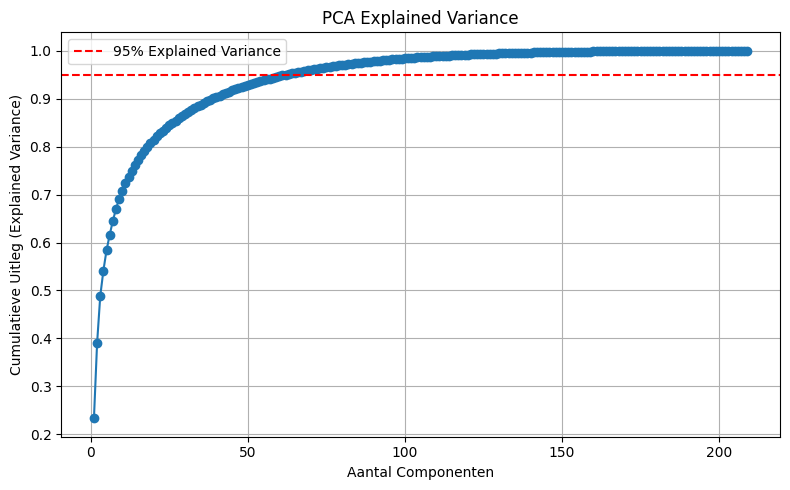

In [375]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA().fit(X_train_reduced_df)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Aantal Componenten')
plt.ylabel('Cumulatieve Uitleg (Explained Variance)')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
